In [1]:
import sys
sys.path.append('../src')

import numpy as np
import torch
import pandas as pd
import importlib
from tqdm import tqdm as tqdm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import utils_roughvol
from utils_crops import subsample

import RBF_RBF
import ESig_RBF
import LinSigESig
import deep_sets

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 4),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

We assume that prices follow the following fractional OU process

$$dX_t =  -\alpha(X_t - \mu) + \nu dW^H_t$$

where $W^H_t$ is fBM with H<0.5. This RDE has an explicit solution

$$X_t = \nu \int_{-\infty}^t e^{-\alpha(t-s)}dW_s^H + \mu$$

The Rough Fractional Stochastic Volatility (RFSV) model is defined in https://arxiv.org/pdf/1410.3394.pdf as follows

$$\sigma_t = e^{X_t}$$

In [41]:
tot = 15
l = 300

a1 = 0.00001
a2 = 0.001
a3 = 0.1

list_df_prices = []
list_df_vols = []

for a in [a1, a2, a3]:
    
    df = pd.DataFrame(data=[utils_roughvol.fOU_generator(a,length=l) for k in range(tot)], 
                      columns=range(l+1)).T
    list_df_prices.append(df)

    list_df_vols.append(df.apply(lambda x: np.exp(x)))

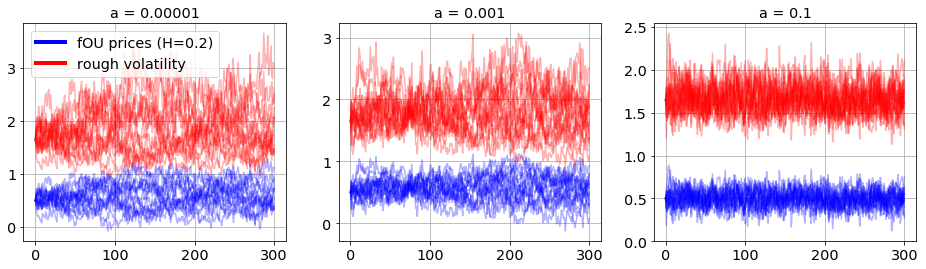

In [43]:
custom_lines = [Line2D([0], [0], color='blue', lw=4), Line2D([0], [0], color='red', lw=4)]

fig, ax = plt.subplots(1, 3)

k=0
for df_p, df_v, a, axx in zip(list_df_prices, list_df_vols, [a1,a2,a3], ax.flatten()):
    if a<1e-4:
        title = 'a = {:.5f}'.format(a)
    else:
        title = 'a = {}'.format(a)
    df_p.plot(grid=True, title=title, legend=False, c='blue', alpha=0.3, ax=axx)
    df_v.plot(grid=True, legend=False, c='red', alpha=0.3, ax=axx)
    if k==0:
        axx.legend(custom_lines, ['fOU prices (H=0.2)', 'rough volatility'])
    k+=1

# s = fig.subplotpars
# bb=[s.left+0.22, s.top+0.1, s.right-0.56, 0.2]

# leg = ax[0].legend(custom_lines, ['fOU prices (H=0.2)', 'volatility'], 
#                    loc=8, bbox_to_anchor=bb, ncol= 2, mode="expand", borderaxespad=0, bbox_transform=fig.transFigure, 
#                    fancybox=False, edgecolor="k")
# leg.get_frame().set_linewidth(72./fig.dpi)

plt.savefig('../pictures/fOU_rough_vol.png', bbox_inches='tight')
plt.show()

# Set up learning parameters

In [30]:
n_bags = 50
n_items = 20 #20, 50,100
length = 300

max_T = 1e0
min_T = 1e-6
y = np.array((max_T-min_T)*np.random.rand(n_bags)+min_T)

In [34]:
X = []
    
for a in tqdm(y):
    intermediate = []
    for n in range(n_items):
        path = np.exp(utils_roughvol.fOU_generator(a, length=length)).reshape(-1,1)
        intermediate.append(path)
    X.append(intermediate)

100%|██████████| 50/50 [00:05<00:00,  9.76it/s]


# RBF-RBF

In [32]:
importlib.reload(RBF_RBF)

<module 'RBF_RBF' from '../src/RBF_RBF.py'>

In [ ]:
RBF_RBF.model(X,y)

 60%|██████    | 3/5 [02:14<01:23, 41.62s/it]

# ESig-SVM

In [15]:
importlib.reload(ESig_RBF)

<module 'ESig_RBF' from '../src/ESig_RBF.py'>

In [28]:
ESig_RBF.model(X, y, depth=3, ll=[0], at=True, ss=False, mode='krr', NUM_TRIALS=5,  cv=3)

100%|██████████| 5/5 [00:47<00:00,  9.25s/it]


(0.00016428422849660158, 1.487532142825709e-05)

# Pathwise-ESig

In [29]:
LinSigESig.model(X, y, 2, 2, ll=[0], at=False, ss=False, NUM_TRIALS=5, cv=3)

100%|██████████| 5/5 [00:45<00:00,  9.69s/it]


(0.0002524713059319317, 6.336594659599432e-05)

# Neural Net approach (Deep Sets) 

https://arxiv.org/pdf/1703.06114.pdf

In [26]:
importlib.reload(deep_sets)

<module 'deep_sets' from '../src/deep_sets.py'>

In [27]:
batch_size = 20
nb_epoch = 1000

In [39]:
MSEs = []

for j in range(5):
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
    
    train = deep_sets.DataIterator(torch.Tensor(X_train), torch.Tensor(y_train), batch_size, shuffle=True)
    test  = deep_sets.DataIterator(torch.Tensor(X_test), torch.Tensor(y_test), 1)

    model = deep_sets.DeepSet

    t = deep_sets.Trainer(train.d, model, nb_epoch)

    t.fit(train)
    
    MSEs.append(t.evaluate(test))
    
print(np.mean(MSEs), np.std(MSEs))

Train loss: 0.054489
Train loss: 0.004382
Train loss: 0.000468
Train loss: 0.000157
Train loss: 0.000062
Train loss: 1.037078
Train loss: 0.035072
Train loss: 0.018148
Train loss: 0.007036
Train loss: 0.003871
Train loss: 0.086315
Train loss: 0.000205
Train loss: 0.000114
Train loss: 0.000049
Train loss: 0.000013
Train loss: 0.741028
Train loss: 0.045351
Train loss: 0.029810
Train loss: 0.010635
Train loss: 0.002094
Train loss: 0.513346
Train loss: 0.018927
Train loss: 0.008558
Train loss: 0.001034
Train loss: 0.000158
0.09736016398106585 0.019825377069593742


# Deep Set adapted to sequential data: DeepSet-RNN

In [28]:
MSEs = []

for j in range(5):
    
    X = []
    for a in y:
        intermediate = []
        for n in range(n_items):
            intermediate.append(np.exp(utils_roughvol.fOU_generator(a))[:,None])
        X.append(intermediate)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
    
    train = deep_sets.DataIteratorSeq(torch.Tensor(X_train), torch.Tensor(y_train), shuffle=True)
    test  = deep_sets.DataIteratorSeq(torch.Tensor(X_test), torch.Tensor(y_test))
    
    model = deep_sets.DeepSetRNN

    t = deep_sets.Trainer(train.d, model, nb_epoch)

    t.fit(train)
    
    MSEs.append(t.evaluate(test))
    
print(np.mean(MSEs), np.std(MSEs))

Train loss: 0.011718
Train loss: 0.008795
Train loss: 0.000898
Train loss: 0.000000
Train loss: 0.005070
Train loss: 0.512796
Train loss: 0.013416
Train loss: 0.006380
Train loss: 0.006889
Train loss: 0.002711
Train loss: 0.226459
Train loss: 0.000056
Train loss: 0.001370
Train loss: 0.000276
Train loss: 0.000353
Train loss: 0.000005
Train loss: 0.000038
Train loss: 0.006325
Train loss: 0.005437
Train loss: 0.004385
Train loss: 0.000289
Train loss: 0.000234
Train loss: 0.000164
Train loss: 0.000044
Train loss: 0.013716
0.1036146944295615 0.02346307736066108


# Deep Set adapted to sequential data: DeepSet-GRU

In [29]:
MSEs = []

for j in range(5):
        
    X = []
    for a in y:
        intermediate = []
        for n in range(n_items):
            intermediate.append(np.exp(utils_roughvol.fOU_generator(a))[:,None])
        X.append(intermediate)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
    
    train = deep_sets.DataIteratorSeq(torch.Tensor(X_train), torch.Tensor(y_train), shuffle=True)
    test  = deep_sets.DataIteratorSeq(torch.Tensor(X_test), torch.Tensor(y_test))

    model = deep_sets.DeepSetGRU

    t = deep_sets.Trainer(train.d, model, nb_epoch)

    t.fit(train)
    
    MSEs.append(t.evaluate(test))
    
print(np.mean(MSEs), np.std(MSEs))

Train loss: 0.125444
Train loss: 0.021199
Train loss: 0.000017
Train loss: 0.000188
Train loss: 0.000001
Train loss: 0.059367
Train loss: 0.000000
Train loss: 0.009267
Train loss: 0.000000
Train loss: 0.000002
Train loss: 0.617660
Train loss: 0.002672
Train loss: 0.000001
Train loss: 0.000413
Train loss: 0.000009
Train loss: 0.128971
Train loss: 0.000059
Train loss: 0.000000
Train loss: 0.000053
Train loss: 0.000000
Train loss: 0.527531
Train loss: 0.000132
Train loss: 0.000000
Train loss: 0.000134
Train loss: 0.000223
0.12901226140852032 0.03190233810688324


# Deep Set adapted to sequential data: DeepSet-LSTM

In [42]:
MSEs = []

for j in range(5):
    
    X = []
    for a in y:
        intermediate = []
        for n in range(n_items):
            intermediate.append(np.exp(utils_roughvol.fOU_generator(a))[:,None])
        X.append(intermediate)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
    
    train = deep_sets.DataIterator(torch.Tensor(X_train), torch.Tensor(y_train), batch_size, shuffle=True)
    test  = deep_sets.DataIterator(torch.Tensor(X_test), torch.Tensor(y_test), 1)

    model = deep_sets.DeepSetLSTM

    t = deep_sets.Trainer(train.d, model, nb_epoch)

    t.fit(train)
    
    MSEs.append(t.evaluate(test))
    
print(np.mean(MSEs), np.std(MSEs))

Train loss: 14.156323
Train loss: 0.006026
Train loss: 0.004821
Train loss: 0.003121
Train loss: 0.002109
Train loss: 4.484265
Train loss: 0.004233
Train loss: 0.000391
Train loss: 0.000001
Train loss: 0.000000
Train loss: 0.342505
Train loss: 0.001452
Train loss: 0.000001
Train loss: 0.000000
Train loss: 0.000000
Train loss: 0.100298
Train loss: 0.001007
Train loss: 0.000270
Train loss: 0.000046
Train loss: 0.000028
Train loss: 0.074023
Train loss: 0.000061
Train loss: 0.000004
Train loss: 0.000146
Train loss: 0.000146
0.11570959871275703 0.04315897767986933
